In [14]:
# Imports

from datetime import datetime, timedelta

from Database import db
 
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt

from keras.optimizers import RMSprop
from keras.models import Sequential, load_model, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, concatenate, SpatialDropout1D, GRU
from keras.layers import Dense, Flatten, Embedding, LSTM, Activation, BatchNormalization, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import keras.backend as K
from keras.utils import plot_model

In [40]:
# Options

stocks      = ['AAPL', 'AMD', 'AMZN', 'GOOG', 'MSFT', 'INTC']
all_sources = ['reddit', 'reuters', 'twitter', 'seekingalpha', 'fool', 'wsj', 'thestreet']

tick_window = 30
max_length  = 50
vocab_size  = None # Set by tokenizer
emb_size    = 300

model_type  = 'regression'

epochs      = 250
batch_size  = 64

In [41]:

def add_time(date, days):
    
    return (date + timedelta(days=days)).strftime('%Y-%m-%d')

def make_headline_to_effect_data():
    """
    Headline -> Effect
    
    Creates essentially the X, Y data for the embedding model to use
    when analyzing/encoding headlines. Returns a list of headlines and
    a list of corresponding 'effects' which represent a change in the stock price.
    """
    meta, headlines, tick_hists, effects = [], [], [], []
    
    with db() as (conn, cur):
        
        for stock in stocks:
            
            print("Fetching Stock..." + stock)
            
            ## Go through all the headlines ##
            
            cur.execute("SELECT date, source, content, sentimentlabel FROM headlines WHERE stock=?", [stock])
            headline_query = cur.fetchall()
            
            for (date, source, content, label) in headline_query:
                
                if not (3 <= content.count(' ') <= 40):
                    continue
                
                event_date = datetime.strptime(date, '%Y-%m-%d') # The date of headline
                
                ## Find corresponding tick data ## 
                
                cur.execute("""SELECT open, high, low, adjclose, volume FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date DESC""", 
                            [stock, 
                             add_time(event_date, -30 - tick_window), 
                             add_time(event_date, 0)])
                
                before_headline_ticks = cur.fetchall()[:tick_window]
                
                if len(before_headline_ticks) != tick_window:
                    continue
                
                cur.execute("""SELECT AVG(adjclose) FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                            [stock, 
                             add_time(event_date, 1), 
                             add_time(event_date, 4)])
                
                after_headline_ticks = cur.fetchall()
                
                ## Create training example ##
                
                previous_tick = before_headline_ticks[0][3]
                result_tick = after_headline_ticks[0][0]
                
                if previous_tick and result_tick and len(after_headline_ticks) > 0:
                    
                    tick_hist = np.array(before_headline_ticks)
                    tick_hist -= np.mean(tick_hist, axis=0)
                    tick_hist /= np.std(tick_hist, axis=0)
                    
                    if model_type == 'regression':
                        
                        # Percent Diff (+Normalization Constant)
                        effect = [(result_tick - previous_tick) / previous_tick / 0.023]
                        
                        # Use labels to adjust effect
                        if label in [-1, 0, 1]:
                            if np.sign(label) == np.sign(effect[0]):
                                effect = [effect[0] * 2]
                            else:
                                effect = [effect[0] / 4]
                    
                    else:
                
                        if result_tick > previous_tick:
                            effect = [1., 0.]
                        else:
                            effect = [0., 1.]
                            
                        if label != -999:
                            if np.sign(label) != np.sign(effect[0]):
                                effect = [.5, .5]
                        
                    meta.append((source, event_date.weekday()))
                    headlines.append(content)
                    tick_hists.append(tick_hist)
                    effects.append(effect)
                    
    return meta, headlines, np.array(tick_hists), np.array(effects)


In [42]:

def encode_sentences(meta, sentences, tokenizer=None, max_length=100, vocab_size=100):
    """
    Encoder
    
    Takes a list of headlines and converts them into vectors
    """
    ## Encoding Sentences
    
    if not tokenizer:
        
        tokenizer = Tokenizer(num_words=vocab_size, filters='', lower=False) # Already Preprocessed
    
        tokenizer.fit_on_texts(sentences)
    
    encoded_headlines = tokenizer.texts_to_sequences(sentences)
    
    padded_headlines = pad_sequences(encoded_headlines, maxlen=max_length, padding='post')
    
    ## Encoding Meta Data
    
    # OneHot(Source [reddit/twitter/reuters etc..]) + OneHot(WeekDay)
    
    meta_matrix = np.zeros((len(sentences), len(all_sources) + 7))
    index = 0
    
    for (source, weekday) in meta:
        
        meta_matrix[index, all_sources.index(source)] = 1
        meta_matrix[index, len(all_sources) + weekday] = 1
        
        index += 1
    
    return meta_matrix, padded_headlines, tokenizer


In [43]:

def split_data(X, X2, X3, Y, ratio): #TODO Make Better
    """
    Splits X/Y to Train/Test
    """
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    
    X  = X[indexes]
    X2 = X2[indexes]
    X3 = X3[indexes]
    Y  = Y[indexes]
    
    train_size = int(len(X) * ratio)
    
    trainX,  testX  = X[:train_size],  X[train_size:]
    trainX2, testX2 = X2[:train_size], X2[train_size:]
    trainX3, testX3 = X3[:train_size], X3[train_size:]
    trainY,  testY  = Y[:train_size],  Y[train_size:]
    
    return trainX, trainX2, trainX3, trainY, testX, testX2, testX3, testY


In [ ]:

def get_embedding_matrix(tokenizer, use_glove=True, pretrained_file='glove.840B.300d.txt', purge=False):
    """Load Vectors from Glove File"""
    print("Loading WordVecs...")
    
    embedding_matrix = np.zeros((vocab_size + 1, emb_size))
    
    if not use_glove:
        return embedding_matrix, None
    
    ## Load Glove File (Super Slow) ##
    
    glove_db = dict()
    
    with open(os.path.join('..', 'data', pretrained_file), 'r', encoding="utf-8") as glove:

        for line in glove:

            values = line.split(' ')
            word = values[0].replace('-', '').lower()
            coefs = np.asarray(values[1:], dtype='float32')
            glove_db[word] = coefs

    print('Loaded WordVectors...' + str(len(glove_db)))
    
    ## Set Embeddings ##
    
    for word, i in tokenizer.word_index.items():
        
        embedding_vector = glove_db.get(word)
        
        if embedding_vector is not None:
            
            embedding_matrix[i] = embedding_vector
            
        elif purge:
            
            with db() as (conn, cur):
                
                cur.execute("SELECT 1 FROM dictionary WHERE word=? AND stock=?", [word, "none"])
                
                if len(cur.fetchall()) == 0:
                    
                    print("Purge..." + word)

                    #cur.execute("DELETE FROM headlines WHERE content LIKE ?", ["%" + word + "%"])
                    #conn.commit()
            
    return embedding_matrix, glove_db

def correct_sign_acc(y_true, y_pred):
    """
    Accuracy of Being Positive or Negative
    """
    diff = K.equal(y_true > 0, y_pred > 0)
    
    return K.mean(diff, axis=-1)

def get_model(emb_matrix):
    
    ## Headline ##
    
    headline_input = Input(shape=(max_length,), name="headlines")
    
    emb = Embedding(vocab_size + 1, emb_size, input_length=max_length, weights=[emb_matrix], trainable=True)(headline_input)
    emb = SpatialDropout1D(.2)(emb)
    
    # conv = Conv1D(filters=64, kernel_size=5, padding='same', activation='selu')(emb)
    # conv = MaxPooling1D(pool_size=3)(conv)
    
    text_rnn = LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=False)(emb)
    text_rnn = Activation('selu')(text_rnn)
    text_rnn = BatchNormalization()(text_rnn)
    
    # text_rnn = LSTM(300, dropout=0.3, recurrent_dropout=0.3)(text_rnn)
    # text_rnn = Activation('relu')(text_rnn)
    # text_rnn = BatchNormalization()(text_rnn)
    
    ## Ticks ##
    
    tick_input = Input(shape=(tick_window, 5), name="stockticks")
    
    tick_conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='selu')(tick_input)
    tick_conv = MaxPooling1D(pool_size=2)(tick_conv)
    
    tick_rnn = LSTM(200, dropout=0.4, recurrent_dropout=0.4, return_sequences=False)(tick_conv)
    tick_rnn = Activation('selu')(tick_rnn)
    tick_rnn = BatchNormalization()(tick_rnn)
    
    ## Meta ##
    
    meta_input = Input(shape=(len(all_sources) + 7,), name="metadata")
    
    ## Combined ##
    
    merged = concatenate([text_rnn, tick_rnn, meta_input])
    
    final_dense = Dense(300)(merged)
    final_dense = Activation('selu')(final_dense)
    final_dense = BatchNormalization()(final_dense)
    final_dense = Dropout(0.5)(final_dense)
    
    final_dense = Dense(100)(merged)
    final_dense = Activation('selu')(final_dense)
    final_dense = BatchNormalization()(final_dense)
    final_dense = Dropout(0.5)(final_dense)
    
    if model_type == 'regression':
        
        pred_dense = Dense(1)(final_dense)
        out = pred_dense
        
        model = Model(inputs=[headline_input, tick_input, meta_input], outputs=out)
    
        model.compile(optimizer=RMSprop(lr=0.001), loss='mse', metrics=[correct_sign_acc])
    
    else:
    
        pred_dense = Dense(2)(final_dense)
        out = Activation('softmax')(pred_dense)
        
        model = Model(inputs=[headline_input, tick_input, meta_input], outputs=out)
    
        model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
    
    return model


In [ ]:

if __name__ == "__main__":
    
    meta, headlines, tick_hists, effects = make_headline_to_effect_data()
    
    encoded_meta, encoded_headlines, toke = encode_sentences(meta, 
                                                             headlines, 
                                                             max_length=max_length, 
                                                             vocab_size=vocab_size)
    
    vocab_size = len(toke.word_counts)
    print("Found Words......" + str(vocab_size))
    
    emb_matrix, glove_db = get_embedding_matrix(toke, purge=True)
    
    trainX, trainX2, trainX3, trainY, testX, testX2, testX3, testY = split_data(encoded_headlines, tick_hists, encoded_meta, effects, .9)
    
    print(trainX.shape, trainX2.shape, trainX3.shape, testY.shape)


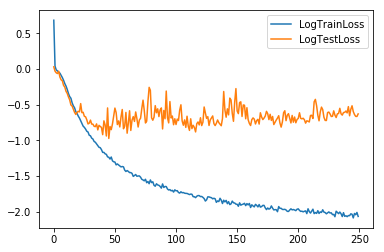

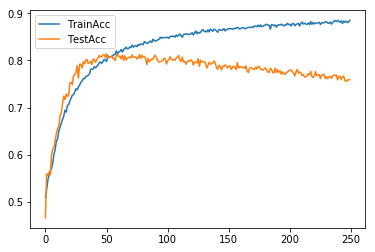

In [8]:
# TRAIN MODEL

if __name__ == "__main__":  
    
    ## Save Tokenizer ##
    
    with open(os.path.join('..', 'models', 'toke-tick.pkl'), 'wb') as toke_file:
        pickle.dump(toke, toke_file, protocol=pickle.HIGHEST_PROTOCOL)
        
    ## Create Model ##
    
    model = get_model(emb_matrix)
    
    if model_type == 'regression':
        monitor_mode = 'correct_sign_acc'
    else:
        monitor_mode = 'val_acc'
    
    tensorboard = TensorBoard(log_dir="logs/{}".format(datetime.now().strftime("%Y,%m,%d-%H,%M,%S,tick," + model_type)))
    e_stopping = EarlyStopping(monitor='val_loss', patience=50)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'), 
                                 monitor=monitor_mode,
                                 verbose=0,
                                 save_best_only=True)
    
    plot_model(model, to_file='model.png', show_shapes=True)
    
    ## Train ##
    
    history = model.fit([trainX, trainX2, trainX3],
                        trainY,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=([testX, testX2, testX3], testY),
                        verbose=0,
                        callbacks=[e_stopping, checkpoint, tensorboard])
    
    ## Display Train History ##
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['LogTrainLoss', 'LogTestLoss'])
    plt.show()
    
    plt.plot(history.history[monitor_mode])
    plt.plot(history.history['val_' + monitor_mode])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
    

In [8]:
# Predict (TEST)

def predict(stock, model=None, toke=None, current_date=None, predict_date=None, look_back=None):
    
    import keras.metrics
    keras.metrics.correct_sign_acc = correct_sign_acc
    
    if not model or not toke:
        
        with open(os.path.join('..', 'models', 'toke-tick.pkl'), 'rb') as toke_file:
            toke = pickle.load(toke_file)
    
        model = load_model(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'))
        
    vocab_size = len(toke.word_counts)
        
    if not current_date:
        current_date = datetime.today()
        
    if not predict_date:
        predict_date = current_date + timedelta(days=1)
        
    if not look_back:
        look_back = 2
    
    pretick_date = add_time(current_date, -look_back)
    
    with db() as (conn, cur):
        
        ## Select Actual Stock Values ##
                
        cur.execute("""SELECT open, high, low, adjclose, volume FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date DESC""", 
                    [stock, 
                    add_time(current_date, -10 - tick_window), 
                    add_time(current_date, 0)])
                
        before_headline_ticks = cur.fetchall()[:tick_window]
        actual_current = before_headline_ticks[0][3]
        
        cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC LIMIT 1""", 
                    [stock, 
                    add_time(predict_date, 1), 
                    add_time(predict_date, 5)])
        
        after_headline_ticks = cur.fetchall()
        
        tick_hist = np.array(before_headline_ticks)
        tick_hist -= np.mean(tick_hist, axis=0)
        tick_hist /= np.std(tick_hist, axis=0)
        
        ## Find Headlines ##
    
        cur.execute("SELECT date, source, content FROM headlines WHERE date BETWEEN ? AND ? AND stock=?", [pretick_date, current_date, stock])
        headlines = cur.fetchall()
        
        ## Process ##
        
        meta, test_sents = [], []
        
        for (date, source, content) in headlines:
            
            meta.append([source, datetime.strptime(date, '%Y-%m-%d').weekday()])
            test_sents.append(content)
            
        encoded_meta, test_encoded, _ = encode_sentences(meta, 
                                                         test_sents, 
                                                         tokenizer=toke, 
                                                         max_length=max_length,
                                                         vocab_size=vocab_size)
        
        tick_hists = np.array([tick_hist] * len(headlines))
        
        predictions = model.predict([test_encoded, tick_hists, encoded_meta])[:, 0]
        
        prices = predictions * 0.023 * actual_current + actual_current
        
        return predictions, prices 
        

In [10]:
# [TEST] Spot Testing

if __name__ == "__main__":
    
    ## **This Test May Overlap w/Train Data** ##
    
    ## Options ##
    
    stock = 'AMD'
    look_back = 3
    current_date = '2018-02-27'
    predict_date = '2018-02-28'
    
    ## Run ##
    
    predictions, prices = predict(stock, 
                                  current_date=datetime.strptime(current_date, '%Y-%m-%d'), 
                                  predict_date=datetime.strptime(predict_date, '%Y-%m-%d'), 
                                  look_back=look_back)
    
    ## Find Actual Value ##
    
    with db() as (conn, cur):
    
        cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC LIMIT 1""", 
                        [stock, 
                        add_time(datetime.strptime(predict_date, '%Y-%m-%d'), 0), 
                        add_time(datetime.strptime(predict_date, '%Y-%m-%d'), 6)])

        after_headline_ticks = cur.fetchall()
        try:
            actual_result = after_headline_ticks[0][0]
        except:
            actual_result = -1
            
    ## Display ##
            
    parse = lambda num: str(round(num, 2))
    
    print("Predicting Change Coef: " + parse(np.mean(predictions)))
    print("Predicting Price: " + parse(np.mean(prices)))
    print("Actual Price: " + parse(actual_result))
            

Predicting Change Coef: 0.97
Predicting Price: 12.81
Actual Price: -1


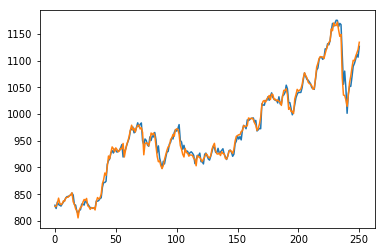

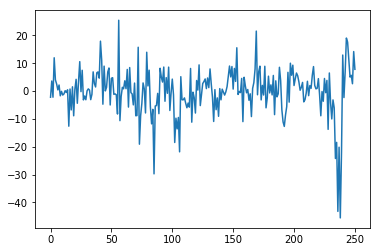

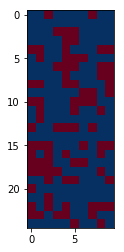

In [11]:
# [TEST] Range Test

if __name__ == "__main__":
    
    ## Load Model For Manual Testing ##
    
    import keras.metrics
    keras.metrics.correct_sign_acc = correct_sign_acc
    
    with open(os.path.join('..', 'models', 'toke-tick.pkl'), 'rb') as toke_file:
        toke = pickle.load(toke_file)
    
    model = load_model(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'))
    
    ## **This Test May Overlap w/Train Data** ##
    
    ## Settings ##
    
    stock = 'GOOG'
    start_date = '2017-02-25'
    end_date = '2018-02-25'
    
    ## Run ##
    
    with db() as (conn, cur):
        
        cur.execute("""SELECT date, adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC""", 
                    [stock, 
                     datetime.strptime(start_date, '%Y-%m-%d'), 
                     datetime.strptime(end_date, '%Y-%m-%d')])
        
        real_ticks = cur.fetchall()
        dates = sorted([ date for date, _ in real_ticks])
        real_ticks = { date: close for (date, close) in real_ticks }
        fake_ticks = { date: -1 for date in real_ticks }
        
    for date in dates:
            
        predict_date = datetime.strptime(date, '%Y-%m-%d')
            
        predictions, prices = predict(stock, 
                                      model=model,
                                      toke=toke,
                                      current_date=predict_date + timedelta(days=-1), 
                                      predict_date=predict_date, 
                                      look_back=3)
            
        fake_ticks[date] = np.mean(prices)
        
    real_ticks = np.array([real_ticks[date] for date in dates])
    fake_ticks = np.array([fake_ticks[date] for date in dates])
        
    plt.plot(real_ticks)
    plt.plot(fake_ticks)
    plt.show()
        
    plt.plot(fake_ticks - real_ticks)
    plt.show() 
    
    acc_image = np.array([np.sign(fake_ticks[1:] - fake_ticks[:-1]) == np.sign(real_ticks[1:] - real_ticks[:-1])]) * 1.0
    acc_image = acc_image.reshape((25, 10))

    plt.imshow(acc_image, interpolation='none', cmap='RdBu')
    plt.show()
            

In [12]:
# [TEST] Caeteris Paribus

# if __name__ == "__main__":
     
#     ## Load Model For Manual Testing ##
    
#     import keras.metrics
#     keras.metrics.correct_sign_acc = correct_sign_acc
     
#     with open(os.path.join('..', 'models', 'toke-tick.pkl'), 'rb') as toke_file:
#         toke = pickle.load(toke_file)
    
#     model = load_model(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'))
      
#     ## Fake Unique Test Data ##
    
#     headlines = [
#         "**COMPANY** gains a ton of stock after creating **PRODUCT**",
#         "**COMPANY** loses a ton of stock after killing **PRODUCT**"
#     ]
    
#     test_sents, meta = [], []
    
#     for headline in headlines:
    
#         for source in all_sources:

#             for weekday in range(7):
            
#                 test_sents.append(headline)
#                 meta.append([source, weekday])
    
#     ## Process ##
    
#     encoded_meta, test_encoded, _ = encode_sentences(meta, 
#                                                      test_sents, 
#                                                      tokenizer=toke, 
#                                                      max_length=max_length, 
#                                                      vocab_size=vocab_size)
    
#     predictions = model.predict([test_encoded, encoded_meta])
    
#     predictions = predictions.reshape((len(headlines), len(all_sources), 7))
    
#     ## Display Predictions ##
    
#     from matplotlib.colors import Normalize
    
#     for i, headline in enumerate(headlines):
        
#         plt.imshow(predictions[i], interpolation='none', cmap='PRGn', norm=Normalize(vmin=-2, vmax=2))
#         plt.title(headline)
#         plt.xlabel('Weekday')
#         plt.ylabel('Source')
#         plt.xticks(np.arange(7), list('MTWTFSS'))
#         plt.yticks(np.arange(len(all_sources)), all_sources)
#         plt.show()
